# Table of Contents<a id='Table_of_Contents'></a>

* [Table of Contents](#Table_of_Contents)
* [Import Packages](#Import_Packages)
* [Functions](#Functions)
* [Exploratory Data Analysis](#Exploratory_Data_Analysis)
* [Experiment and Metrics Design](#Experiment_and_Metrics_Design)
* [Predictive Modeling](#Predictive_Modeling)
  * [Define Data](#Define_Data)
      * [Data Dictionary](#Data_Dictionary)
      * [Import Data](#Import_Data)
  * [Data Cleaning](#Data_Cleaning)
      * [Check for Duplicate Rows](#Check_for_Duplicate_Rows)
      * [Check for Null Values](#Check_for_Null_Values)
          * [avg_rating_of_driver](#avg_rating_of_driver)
          * [phone](#phone)
          * [avg_rating_by_driver](#avg_rating_by_driver)     
  * [Explore the Data](#Explore_the_Data)
      * [city](#city)
      * [phone](#phone2)
      * [signup_date](#signup_date)
      * [last_trip_date](#last_trip_date)
      * [avg_dist](#avg_dist)
      * [avg_rating_by_driver](#avg_rating_by_driver2)
      * [avg_rating_of_driver](#avg_rating_of_driver2)
      * [surge_pct](#surge_pct)
      * [avg_surge](#avg_surge)
      * [trips_in_first_30_days](#trips_in_first_30_days)
      * [ultimate_black_user](#ultimate_black_user)
      * [weekday_pct](#weekday_pct)
  * [Target Value](#Target_Value)
  * [Analysis](#Analysis)
* [Modeling](#Modeling)
  * [Scaling the Data](#Scaling_the_Data)
  * [Logistic Regression](#Logistic_Regression)
  * [Random Forest](#Random_Forest)
* [Conclusion](#Conclusion)

# Import Packages<a id='Import_Packages'>

In [1]:
#IMPORTS

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Functions<a id='Functions'></a>

In [2]:
def resample_time(data,sample='15T'):
    return data.resample(sample).size().reset_index(name='count')

In [3]:
def plot_time(data):
    plt.figure(figsize=(12, 6)) 
    plt.plot(data.index, data['count'],  linestyle='-')
    date_format = DateFormatter('%m/%d/%Y')
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.show()

In [4]:
def countplot(data,column,bars=10, hue=None,legend_title=None,legend=True):
    plt.clf()
    
    counts = data[column].value_counts().sort_values(ascending=False).nlargest(bars)
    
    
    ax = sns.countplot(y=column, data= data,order=counts.index,hue=hue)
    
    for p in ax.patches:
        ax.annotate(format(p.get_width(), '.0f'), (p.get_width() + 5, p.get_y() + p.get_height() / 2), ha = 'left', va = 'center')

    if legend:
        ax.legend(loc='lower right',title=legend_title)
    else:
        ax.legend_ = None
    
    plt.show()

# Exploratory Data Analysis<a id='Exploratory_Data_Analysis'></a>

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15 minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

Let's first import the data and view it.

In [5]:
# Import Data  logins.json
with open('logins.json', 'r') as json_file:
    data = json.load(json_file)

In [6]:
login_df = pd.DataFrame.from_dict(data, orient='index').T

In [7]:
login_df

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
...,...
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38


There is just the one column with login_time. Let's get some initial views of the data.

In [8]:
login_df.describe()

,login_time
count,93142
unique,92265
top,1970-03-17 01:01:39
freq,3


In [9]:
login_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   login_time  93142 non-null  object
dtypes: object(1)
memory usage: 727.8+ KB


In [10]:
login_df.isnull().sum()

login_time    0
dtype: int64

Mostly unique values for login times, with the max frequency being 3. Duplicates would be okay in this scenario as multiple logins could occur at the same time. We also see there are no null values. Let's make the time the index of the dataframe so we can do some manipulations. 

In [11]:
login_df['login_time'] = pd.to_datetime(login_df['login_time'])
login_df.set_index('login_time', inplace=True)

login_df

""
login_time
1970-01-01 20:13:18
1970-01-01 20:16:10
1970-01-01 20:16:37
1970-01-01 20:16:36
1970-01-01 20:26:21
...
1970-04-13 18:50:19
1970-04-13 18:43:56
1970-04-13 18:54:02


Now that the times are in the index, we can resample the time so it gets a count for every time that falls within 15 minute periods. 

In [12]:
int_login_df = resample_time(login_df,'15T')

int_login_df.set_index('login_time', inplace=True)

In [13]:
int_login_df

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2


We see a count column was added with the amount of logins within that 15 minute period. Let's see what the distribution of the data looks like.

In [14]:
int_login_df.describe()

,count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


We see that the mean of counts is 9.5, so we can then plot the data to see what it looks like when combined for every 15 minutes. 

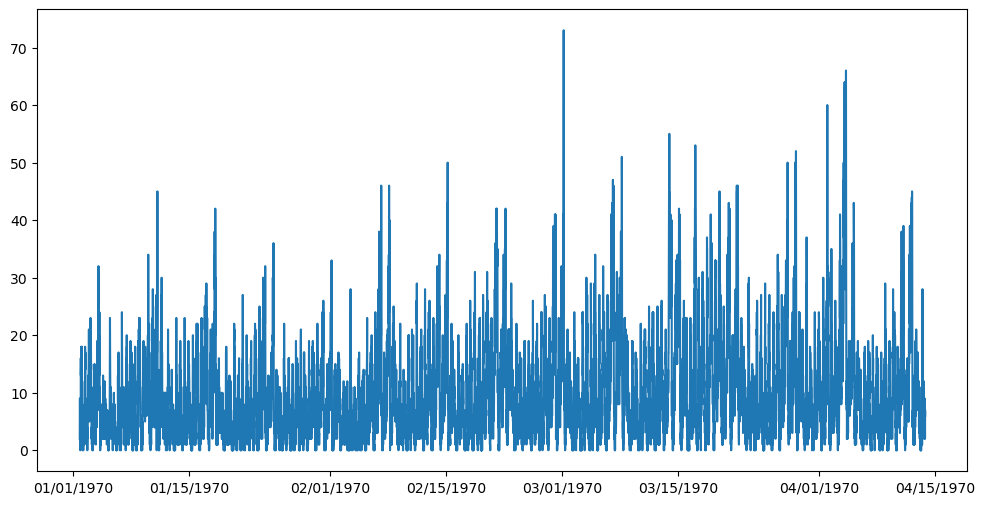

In [15]:
plot_time(int_login_df)

We see there is a lot of data, but there is a general trend with highs and lows throughout. With the mean being 9.5, we see the spikes go way above that even up to 70. There also looks like there could be a slight upward trend toward the end in regards to the mean. Let's look at a graph of just 1 day. 

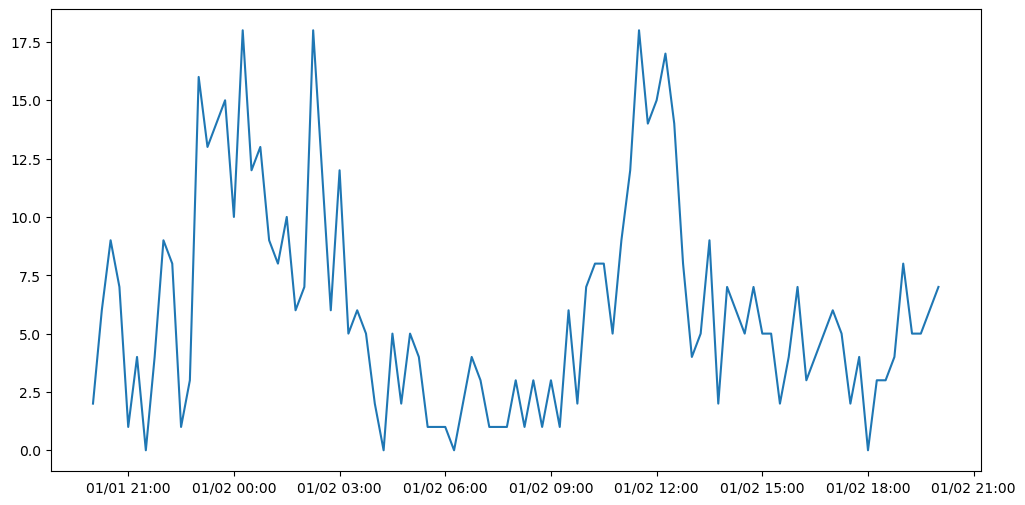

In [16]:
first_day = int_login_df[0:97]


plt.figure(figsize=(12, 6)) 
plt.plot(first_day.index, first_day['count'],  linestyle='-')
date_format = DateFormatter('%m/%d %H:%M')
plt.gca().xaxis.set_major_formatter(date_format)
plt.show()

We see a bit smoother of a graph, with spikes around the 12AM and 12PM times. Let's now look at the graph for the entire dataset when the counts are conglomerated by day. 

In [17]:
day_login_df = resample_time(login_df,'D')

day_login_df

,login_time,count
0,1970-01-01,112
1,1970-01-02,681
2,1970-01-03,793
3,1970-01-04,788
4,1970-01-05,459
...,...,...
98,1970-04-09,818
99,1970-04-10,1009
100,1970-04-11,1352
101,1970-04-12,1409


In [18]:
day_login_df.describe()

,count
count,103.000000
mean,904.291262
std,347.167463
min,112.000000
25%,643.000000
50%,827.000000
75%,1141.000000
max,1889.000000


We see the mean for the counts when combined for each day is 904. Let's now take a look at the plot. 

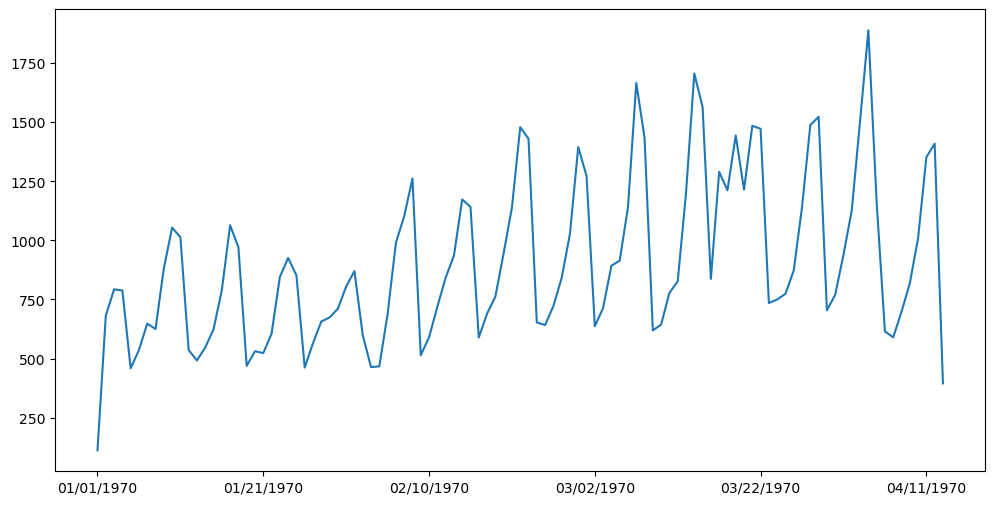

In [19]:
plot_time(day_login_df)

When looking at days, we see there are defintely days where the number of logins spike well above the mean. We also see the slight trend upward as well here. Let's see what each day of the week looks like for number of logins to see if there is a trend on a specific day of the week. 

<AxesSubplot:xlabel='day_of_week_S', ylabel='count'>

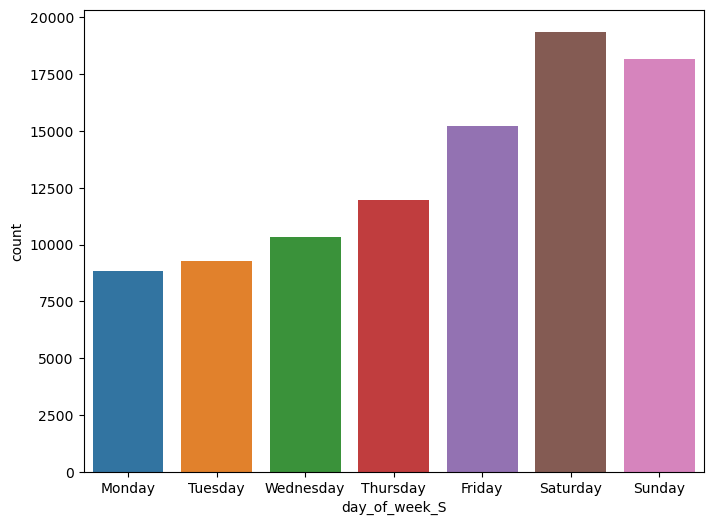

In [20]:
#Let's look at day of the week.

day_of_week = login_df.reset_index()

day_of_week['day_of_week'] = day_of_week['login_time'].dt.dayofweek

sum_day_of_week = day_of_week['day_of_week'].value_counts()


day_of_week['day_of_week_S'] = day_of_week['login_time'].apply(lambda x: x.strftime('%A'))

day_of_week.set_index('login_time', inplace=True)

plt.figure(figsize=(8, 6)) 
sns.countplot(data=day_of_week, x='day_of_week_S',order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

We see that Friday, Saturday, and Sunday is where a majority of the logins are coming from. This is also where we are seeing a spike in the data, so if we wanted to take something away from this data, it would be that logins increase on weekends and demand looks to be slowly rising. 

# Experiment and Metrics Design<a id='Experiment_and_Metrics_Design'></a>

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric? 

**Assuming this data is available, I would want to see increases in usage of the driver partners in the city they are not exclusive in. This would show that they have increased the amount of rides in the other city instead of just staying in the one city. Could also measure to see if the number of tolls taken increases, as well as look at reimbursment claims to see if driving partners are actually using the toll bridge as well as how often.**

2) Describe a practical experiment you would design to compare the effectiveness of theproposed change in relation to the key measure of success. Please provide details on:

    a) how you will implement the experiment. 
    
**Get number of trips before the toll change for each provider and establish what the usual city is that they drive in for each provider. Then after the toll change is in place, we can track those same providers new rides post-toll and get the percentages/totals of rides in each city.**
    
    b) what statistical test(s) you will conduct to verify the significance of the observation

**We can use a T-Test to establish whether the means in each city have changed pre and post toll change.**

    c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.

**We would see if it is successful if we see the amount of rides drivers are taking in the other city increase. We would also want to do a cost analysis to see if the extra availability in drivers is worth reimbursing the tolls or if it's better to keep the driving separate.**

Note: The two cities of Gotham and Metropolis are not in the provided dataset; however, you do
not need this information to answer Part 2.


# Predictive Modeling<a id='Predictive_Modeling'></a>

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.

1) Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

2) Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

3) Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

## Define Data<a id='Define_Data'></a>

We are given the ultimate_data_challenge.json file which contains the following columns.

### Data Dictionary<a id='Data_Dictionary'></a>

● city: city this user signed up in

● phone: primary device for this user

● signup_date: date of account registration; in the form ‘YYYYMMDD’

● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’

● avg_dist: the average distance in miles per trip taken in the first 30 days after signup

● avg_rating_by_driver: the rider’s average rating over all of their trips

● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

● surge_pct: the percent of trips taken with surge multiplier > 1

● avg_surge: The average surge multiplier over all of this user’s trips

● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up

● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE
otherwise

● weekday_pct: the percent of the user’s trips occurring during a weekday


### Import Data<a id='Import_Data'></a>

Let's import the data and take a look at it.

In [21]:
# Import Data
with open('ultimate_data_challenge.json', 'r') as json_file:
    data = json.load(json_file)

In [22]:
df = pd.json_normalize(data)

In [23]:
df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


We see some null values, so we'll have some cleaning we need to do. 

## Data Cleaning<a id='Data_Cleaning'></a>

Let's first check for the data types and see if there are any changes that need to be made. 

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


We see that the two date fields are objects, so we'll want to convert those to datetime fields. We also see there are some missing values in 3 columns as they don't have the full 50,000 non-null values. Let's now check on the duplicate rows.

### Check for Duplicate Rows<a id='Check_for_Duplicate_Rows'></a>

In [25]:
#Check for duplicates
duplicates = df.duplicated(keep=False)
df[duplicates]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
116,Winterfell,1,2014-01-10,5.0,1.0,2014-01-11,Android,0.0,False,100.0,0.00,5.0
332,Astapor,1,2014-01-18,5.0,1.0,2014-01-19,iPhone,0.0,True,0.0,6.25,5.0
2608,Astapor,1,2014-01-18,5.0,1.0,2014-01-19,iPhone,0.0,True,0.0,6.25,5.0
3134,Astapor,1,2014-01-20,5.0,1.0,2014-01-20,iPhone,0.0,False,100.0,3.06,5.0
5958,Winterfell,1,2014-01-18,NaN,1.0,2014-01-19,Android,0.0,False,0.0,0.01,5.0
7836,Astapor,1,2014-01-11,5.0,1.0,2014-01-11,iPhone,0.0,True,0.0,2.33,5.0
10624,Winterfell,1,2014-01-18,5.0,1.0,2014-01-19,Android,0.0,False,0.0,3.54,5.0
14990,Winterfell,1,2014-01-18,NaN,1.0,2014-01-19,iPhone,0.0,True,0.0,1.44,5.0
18057,Astapor,1,2014-01-11,5.0,1.0,2014-01-11,iPhone,0.0,True,0.0,2.33,5.0
26709,Winterfell,1,2014-01-01,NaN,1.0,2014-01-02,Android,0.0,False,100.0,8.08,5.0


We see all the duplicate values rows, 8 unique rows, and 8 duplicate rows. Let's drop the duplicate rows.

In [26]:
#Drop duplicates
df.drop_duplicates(inplace = True)

duplicates = df.duplicated(keep=False)
df[duplicates]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver


We now see there are no more duplicate rows, so that should no longer be an issue. Let's now look for null values. 

### Check for Null Values<a id='Check_for_Null_Values'></a>

In [27]:
#Check for null values
df.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8119
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

Previously, we saw there were 3 columns that were missing data. Those columns are avg_rating_of_driver, phone, and avg_rating_by_driver. Let's fill those values in. 

#### avg_rating_of_driver<a id='avg_rating_of_driver'></a>

For avg_rating_of_driver, we want to fill the missing values in with the mean of that column. This will keep the data consistent and not move any averages for the dataset. 

In [28]:
#We will fill these null values in with the mean of the column avg rating of driver
df[df['avg_rating_of_driver'].isnull()]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
6,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,Android,0.0,False,100.0,3.95,4.0
9,Winterfell,1,2014-01-03,NaN,1.0,2014-01-05,Android,0.0,False,0.0,2.37,5.0
12,Winterfell,1,2014-01-15,NaN,1.0,2014-03-12,iPhone,0.0,False,100.0,20.29,5.0
14,Astapor,1,2014-01-27,NaN,1.0,2014-01-28,Android,0.0,False,100.0,26.01,5.0
15,Winterfell,1,2014-01-15,NaN,1.0,2014-01-16,Android,0.0,True,100.0,13.20,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
49984,Winterfell,1,2014-01-26,NaN,1.0,2014-01-26,Android,0.0,False,0.0,3.50,5.0
49985,Astapor,1,2014-01-26,NaN,1.0,2014-02-25,Android,0.0,False,100.0,1.38,5.0
49989,Winterfell,1,2014-01-24,NaN,1.0,2014-01-31,iPhone,0.0,False,100.0,0.00,5.0
49996,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0


In [29]:
df['avg_rating_of_driver'].mean()

4.60151171399231

The mean is around 4.6 so we will be populating that value in for all the missing values in this column. 

In [30]:
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean())

In [31]:
df[df['avg_rating_of_driver'].isnull()]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver


In [32]:
df[df['avg_rating_of_driver']==df['avg_rating_of_driver'].mean()]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
6,Astapor,1,2014-01-24,4.601512,1.0,2014-01-25,Android,0.0,False,100.0,3.95,4.0
9,Winterfell,1,2014-01-03,4.601512,1.0,2014-01-05,Android,0.0,False,0.0,2.37,5.0
12,Winterfell,1,2014-01-15,4.601512,1.0,2014-03-12,iPhone,0.0,False,100.0,20.29,5.0
14,Astapor,1,2014-01-27,4.601512,1.0,2014-01-28,Android,0.0,False,100.0,26.01,5.0
15,Winterfell,1,2014-01-15,4.601512,1.0,2014-01-16,Android,0.0,True,100.0,13.20,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
49984,Winterfell,1,2014-01-26,4.601512,1.0,2014-01-26,Android,0.0,False,0.0,3.50,5.0
49985,Astapor,1,2014-01-26,4.601512,1.0,2014-02-25,Android,0.0,False,100.0,1.38,5.0
49989,Winterfell,1,2014-01-24,4.601512,1.0,2014-01-31,iPhone,0.0,False,100.0,0.00,5.0
49996,Astapor,1,2014-01-24,4.601512,1.0,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0


The missing values are no more and have been filled in with the proper value. Let's now look at the missing values for the next column.

#### phone<a id='phone'></a>

For phone, we want to fill the missing values in with a new value, "Other". This will account for these missing values as people who had neither an Iphone or Android. It can also allow the model to account for any other types of phones should new data come in that the system doesn't recognize. 

In [33]:
#None means they may have another type of phone, so we can update these to Other. 
df[df['phone'].isnull()]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
134,King's Landing,0,2014-01-10,5.000000,1.00,2014-06-11,None,0.0,False,100.0,2.88,5.0
176,Astapor,0,2014-01-28,5.000000,1.00,2014-03-18,None,0.0,False,100.0,20.32,5.0
320,Astapor,1,2014-01-08,5.000000,1.00,2014-01-09,None,0.0,False,100.0,31.01,5.0
349,Winterfell,1,2014-01-06,3.300000,1.00,2014-06-22,None,0.0,True,33.3,6.03,5.0
389,King's Landing,5,2014-01-26,4.900000,1.02,2014-07-01,None,3.0,False,66.7,3.08,4.8
...,...,...,...,...,...,...,...,...,...,...,...,...
49587,Winterfell,1,2014-01-17,5.000000,1.00,2014-01-19,None,0.0,True,0.0,1.15,3.0
49627,Astapor,6,2014-01-05,5.000000,1.00,2014-01-25,None,0.0,True,33.3,3.10,4.5
49666,Winterfell,2,2014-01-22,4.601512,1.00,2014-01-23,None,0.0,True,100.0,0.73,5.0
49825,Astapor,0,2014-01-25,5.000000,1.00,2014-03-10,None,0.0,True,50.0,5.82,5.0


In [34]:
df['phone'].fillna(value='Other', inplace=True)

In [35]:
df[df['phone'].isnull()]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver


In [36]:
df[df['phone']== 'Other']

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
134,King's Landing,0,2014-01-10,5.000000,1.00,2014-06-11,Other,0.0,False,100.0,2.88,5.0
176,Astapor,0,2014-01-28,5.000000,1.00,2014-03-18,Other,0.0,False,100.0,20.32,5.0
320,Astapor,1,2014-01-08,5.000000,1.00,2014-01-09,Other,0.0,False,100.0,31.01,5.0
349,Winterfell,1,2014-01-06,3.300000,1.00,2014-06-22,Other,0.0,True,33.3,6.03,5.0
389,King's Landing,5,2014-01-26,4.900000,1.02,2014-07-01,Other,3.0,False,66.7,3.08,4.8
...,...,...,...,...,...,...,...,...,...,...,...,...
49587,Winterfell,1,2014-01-17,5.000000,1.00,2014-01-19,Other,0.0,True,0.0,1.15,3.0
49627,Astapor,6,2014-01-05,5.000000,1.00,2014-01-25,Other,0.0,True,33.3,3.10,4.5
49666,Winterfell,2,2014-01-22,4.601512,1.00,2014-01-23,Other,0.0,True,100.0,0.73,5.0
49825,Astapor,0,2014-01-25,5.000000,1.00,2014-03-10,Other,0.0,True,50.0,5.82,5.0


The values have been updated the null values no longer exist. We can move on to the final column with missing values. 

#### avg_rating_by_driver<a id='avg_rating_by_driver'></a>

For avg_rating_by_driver, we want to do the same thing we did for avg_rating_of_driver, which is to fill the missing values in with the mean of that column. This will keep the data consistent and not move any averages for the dataset.

In [37]:
#We will use the mean of the avg rating by driver column to populate these missing values
df[df['avg_rating_by_driver'].isnull()]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
90,Winterfell,1,2014-01-10,5.000000,1.0,2014-02-09,iPhone,0.0,False,0.0,6.28,NaN
274,Astapor,1,2014-01-25,2.000000,4.0,2014-02-09,iPhone,100.0,False,0.0,6.00,NaN
277,Winterfell,1,2014-01-25,4.601512,1.0,2014-01-26,iPhone,0.0,False,0.0,1.82,NaN
536,Winterfell,1,2014-01-18,5.000000,1.0,2014-02-08,Android,0.0,False,100.0,1.41,NaN
857,Winterfell,0,2014-01-11,4.000000,1.0,2014-03-16,iPhone,0.0,False,0.0,0.42,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
49249,King's Landing,0,2014-01-14,5.000000,1.0,2014-06-19,iPhone,0.0,True,100.0,4.60,NaN
49376,Astapor,1,2014-01-20,4.000000,1.0,2014-01-24,iPhone,0.0,False,100.0,3.01,NaN
49504,Winterfell,2,2014-01-24,5.000000,1.0,2014-01-25,Android,0.0,False,100.0,0.75,NaN
49599,King's Landing,1,2014-01-14,5.000000,1.0,2014-02-08,iPhone,0.0,False,100.0,2.48,NaN


In [38]:
df['avg_rating_by_driver'].mean()

4.778122552268482

The mean for this column is around 4.78, so we will populate that as the value for all the missing values. 

In [39]:
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean())

In [40]:
df[df['avg_rating_by_driver'].isnull()]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver


In [41]:
df[df['avg_rating_by_driver']==df['avg_rating_by_driver'].mean()]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
90,Winterfell,1,2014-01-10,5.000000,1.0,2014-02-09,iPhone,0.0,False,0.0,6.28,4.778123
274,Astapor,1,2014-01-25,2.000000,4.0,2014-02-09,iPhone,100.0,False,0.0,6.00,4.778123
277,Winterfell,1,2014-01-25,4.601512,1.0,2014-01-26,iPhone,0.0,False,0.0,1.82,4.778123
536,Winterfell,1,2014-01-18,5.000000,1.0,2014-02-08,Android,0.0,False,100.0,1.41,4.778123
857,Winterfell,0,2014-01-11,4.000000,1.0,2014-03-16,iPhone,0.0,False,0.0,0.42,4.778123
...,...,...,...,...,...,...,...,...,...,...,...,...
49249,King's Landing,0,2014-01-14,5.000000,1.0,2014-06-19,iPhone,0.0,True,100.0,4.60,4.778123
49376,Astapor,1,2014-01-20,4.000000,1.0,2014-01-24,iPhone,0.0,False,100.0,3.01,4.778123
49504,Winterfell,2,2014-01-24,5.000000,1.0,2014-01-25,Android,0.0,False,100.0,0.75,4.778123
49599,King's Landing,1,2014-01-14,5.000000,1.0,2014-02-08,iPhone,0.0,False,100.0,2.48,4.778123


We see that the missing values have been filled in and this column has the correct value now. Let's confirm that we have corrected all the null values. 

In [42]:
#Check for null values
df.isnull().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

We see there are no more null values so we can move on to converting the dates to the proper type. 

### Convert dates to DateTime

As we saw initially, the data types for last_trip_date and signup_date were objects. Let's convert those to datetimes instead so they can better be evaluated as dates. 

In [43]:
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'] )

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49992 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49992 non-null  object        
 1   trips_in_first_30_days  49992 non-null  int64         
 2   signup_date             49992 non-null  datetime64[ns]
 3   avg_rating_of_driver    49992 non-null  float64       
 4   avg_surge               49992 non-null  float64       
 5   last_trip_date          49992 non-null  datetime64[ns]
 6   phone                   49992 non-null  object        
 7   surge_pct               49992 non-null  float64       
 8   ultimate_black_user     49992 non-null  bool          
 9   weekday_pct             49992 non-null  float64       
 10  avg_dist                49992 non-null  float64       
 11  avg_rating_by_driver    49992 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

We see that those two columns are now dates, and the rest of the types look correct. We should be good to explore the data now more in depth. 

## Explore the Data<a id='Explore_the_Data'></a>

We will go column by column to see if we can gleam any insights from the data. We will start with the city field. 

### city<a id='city'></a>

● city: city this user signed up in

In [45]:
#Check all the cities
df.city.value_counts()

Winterfell        23331
Astapor           16531
King's Landing    10130
Name: city, dtype: int64

Looking at all the value counts, we see there are only 3 total cities with the most being in Winterfell, then Astapor, then King's Landing. 

### phone<a id='phone2'></a>

● phone: primary device for this user

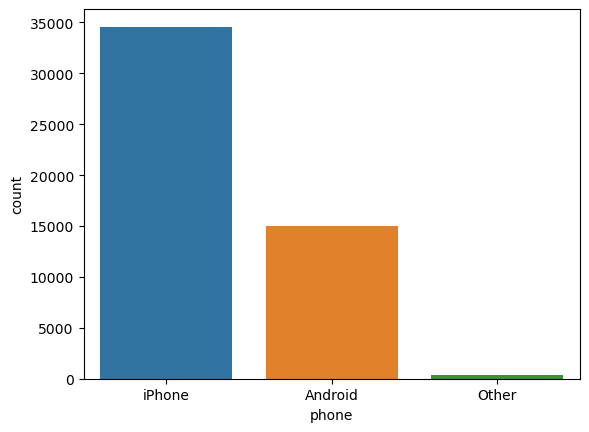

In [46]:
sns.countplot(data=df, x='phone')
plt.show()

For phones, the majority of the users (around 70%) use Iphones for their phone. The rest tend to use Androids, with a few outliers as Other. 

### signup_date<a id='signup_date'></a>

● signup_date: date of account registration; in the form ‘YYYYMMDD’

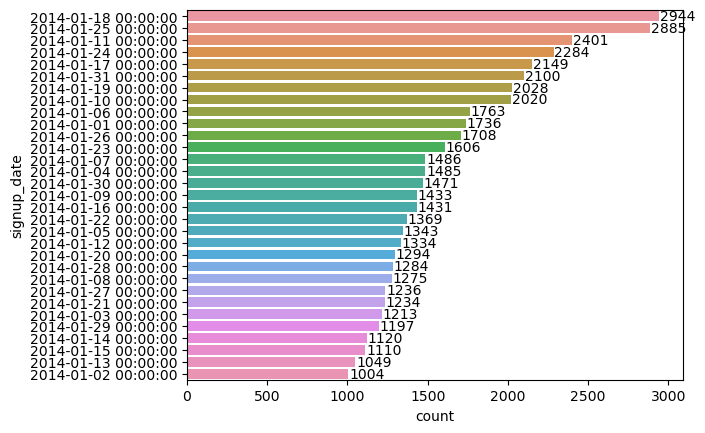

In [47]:
countplot(df,"signup_date",50,legend=False)

With 50,000 data points, we have 31 unique dates. They are all relatively close in scale, but the top 2 dates of 1/18 and 1/25 are ahead of everything else by a significant margin. We do notice that all the signup dates are in the month of January, so this data is tracking specifically people who signed up sometime in January. 

### last_trip_date<a id='last_trip_date'></a>

● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’

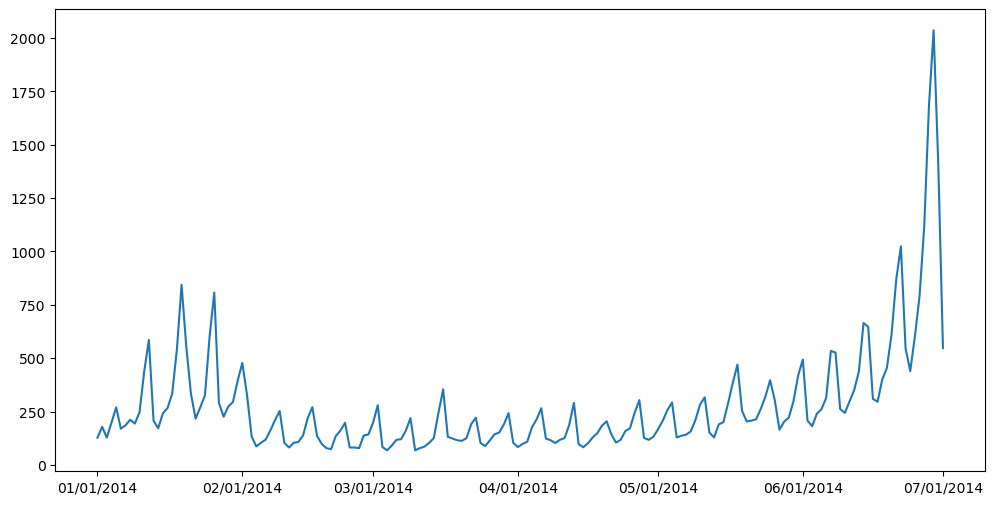

In [48]:
trip = pd.to_datetime(df.last_trip_date)
trip = pd.DataFrame(trip).set_index('last_trip_date')
trip = resample_time(trip,'D')
trip.set_index('last_trip_date', inplace=True)
plot_time(trip)

For the last trip date, we see that there is a spike in January which are the people the tried the service and didn't continue, and then the big spike at the end signify the active users that still use the service. In between those spikes is a stead up and down low variation. 

### avg_dist<a id='avg_dist'></a>

● avg_dist: the average distance in miles per trip taken in the first 30 days after signup

In [49]:
df.avg_dist.describe()

count    49992.00000
mean         5.79726
std          5.70761
min          0.00000
25%          2.42000
50%          3.88000
75%          6.94000
max        160.96000
Name: avg_dist, dtype: float64

In [50]:
df.avg_dist.value_counts()

0.00     149
2.29     116
2.30     116
2.36     114
2.73     114
        ... 
25.07      1
22.34      1
25.43      1
25.78      1
30.39      1
Name: avg_dist, Length: 2908, dtype: int64

For avg_dist, we see there are 2908 unique values where the mean is 5.79, but the max is 160. This is a lot for a countplot, so we will do a histogram instead to bin the values and get an idea of the distribution of the data. The data is signaling that it is heavily skewed in one direction due to 50% of the date falling between 2.42 and 6.94.

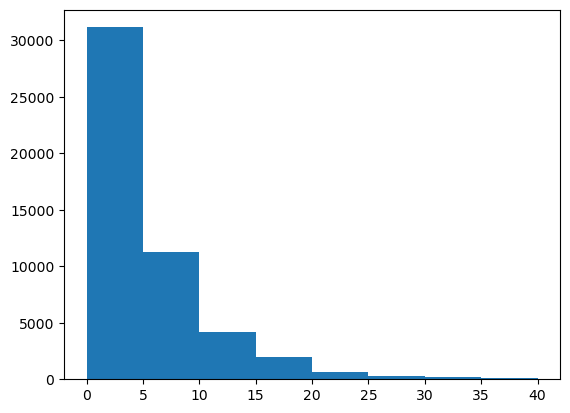

In [51]:
#Majority of the values fall under 40 with extreme outliers. As a result, most trips are short. 
custom_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40]

plt.xticks(custom_bins)
plt.hist(df.avg_dist, bins = custom_bins)
plt.show()

We can confirm that a majority of the data falls under 10. However, we only went to 40 in our histogram, so let's see what the remaining values look like. 

In [52]:
df[df.avg_dist > 40]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
534,King's Landing,0,2014-01-04,4.601512,1.0,2014-03-09,Other,0.0,False,0.0,129.89,5.0
799,Astapor,0,2014-01-28,5.000000,1.0,2014-05-15,Android,0.0,False,100.0,60.58,5.0
891,King's Landing,0,2014-01-19,5.000000,1.0,2014-03-07,iPhone,0.0,False,100.0,43.71,5.0
1302,Winterfell,1,2014-01-30,5.000000,1.0,2014-01-30,iPhone,0.0,False,100.0,79.69,5.0
1482,King's Landing,1,2014-01-08,4.601512,1.0,2014-01-10,Android,0.0,False,100.0,52.15,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
48134,Winterfell,1,2014-01-24,4.601512,1.0,2014-01-26,iPhone,0.0,False,0.0,42.66,5.0
48887,Winterfell,0,2014-01-17,5.000000,1.0,2014-04-13,iPhone,0.0,False,0.0,53.99,5.0
48934,Astapor,0,2014-01-10,4.601512,1.0,2014-05-14,iPhone,0.0,True,100.0,42.46,5.0
49170,Astapor,1,2014-01-01,5.000000,1.0,2014-01-23,iPhone,0.0,False,100.0,41.83,5.0


We see only 113 rows have an avg_dist > 40, so there are not that many users with that distance. There could be some issues with those high values, but we would want to check with Ultimate to look specifically at those users to see if those are correct values. We will keep them for now for the purposes of this analysis.  

### avg_rating_by_driver<a id='avg_rating_by_driver2'></a>

● avg_rating_by_driver: the rider’s average rating over all of their trips

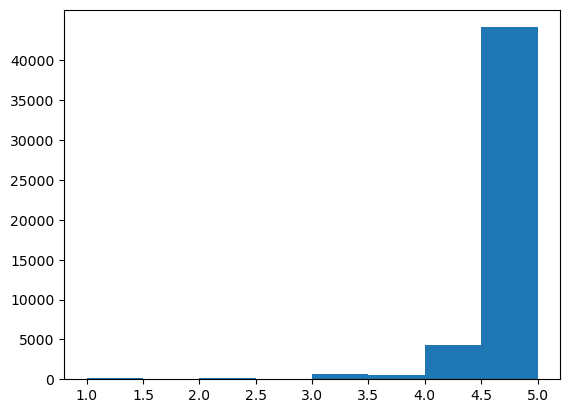

In [53]:
plt.hist(df.avg_rating_by_driver, bins =8)
plt.yticks([0,5000,10000,15000,20000,25000,30000,35000,40000])
plt.show()

Looking at the overall buckets of where ratings fell, we see a majority are positive ratings bewteen 4.5-5.0. 

In [54]:
df.avg_rating_by_driver.value_counts()

5.000000    28500
4.800000     4537
4.700000     3330
4.900000     3094
4.500000     2424
4.600000     2078
4.000000     1914
4.300000     1018
4.400000      860
3.000000      602
4.200000      342
4.778123      201
3.500000      199
3.700000      195
1.000000      181
2.000000      126
4.100000      125
3.800000      111
3.300000       47
3.900000       41
2.500000       31
3.600000       19
3.400000        5
1.500000        4
2.800000        3
3.200000        2
2.700000        2
2.300000        1
Name: avg_rating_by_driver, dtype: int64

We see that a vast majority of the ratings are 5.0, with a majority of the overall dataset being 4.0 and above. 

In [55]:
df.avg_rating_by_driver.describe()

count    49992.000000
mean         4.778123
std          0.445780
min          1.000000
25%          4.700000
50%          5.000000
75%          5.000000
max          5.000000
Name: avg_rating_by_driver, dtype: float64

Looking at the mean and the distribution of the data, we see that those high scores definitely are keeping the mean really high with an average of 4.78 stars. 

### avg_rating_of_driver<a id='avg_rating_of_driver2'></a>

● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

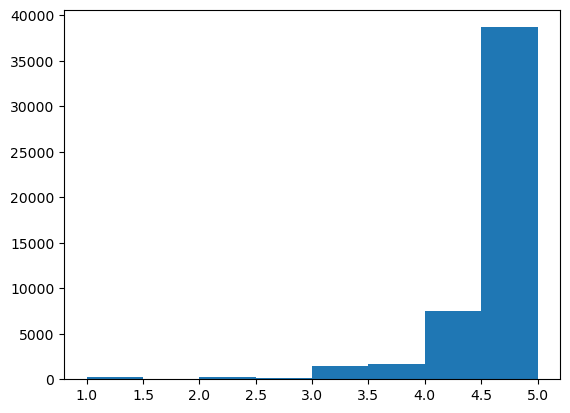

In [56]:
plt.hist(df.avg_rating_of_driver, bins = 8)
plt.show()

Doing a similar analysis for the rating of the drivers, we see the similar skew toward the 4.5-5.0 bucket. However, there are slightly more values in the 4.0-4.5 range. 

In [57]:
df.avg_rating_of_driver.value_counts()

5.000000    20766
4.601512     8119
4.000000     4193
4.500000     2498
4.800000     2430
4.700000     1945
4.900000     1771
4.300000     1487
4.600000     1143
3.000000     1003
4.400000      829
4.200000      601
3.500000      488
3.800000      428
4.100000      398
3.700000      364
1.000000      256
3.900000      255
2.000000      209
3.300000      201
3.600000      172
3.400000      108
2.500000       94
3.200000       53
2.700000       47
3.100000       39
2.800000       28
2.300000       22
2.900000       13
2.600000       12
2.100000        6
1.500000        4
2.400000        3
1.700000        2
1.800000        2
1.900000        1
1.600000        1
2.200000        1
Name: avg_rating_of_driver, dtype: int64

Looking at the value counts, we see 5.0 is still the highest value, but falls short when compared to the avg_rating_by_driver by over 8,000 values. This means that the drivers rate the users higher than the users rate the drivers on average. 

In [58]:
df.avg_rating_of_driver.describe()

count    49992.000000
mean         4.601512
std          0.565008
min          1.000000
25%          4.500000
50%          4.700000
75%          5.000000
max          5.000000
Name: avg_rating_of_driver, dtype: float64

Looking at the mean, this backs up this fact as the mean is slightly lower at 4.6

### surge_pct<a id='surge_pct'></a>

● surge_pct: the percent of trips taken with surge multiplier > 1

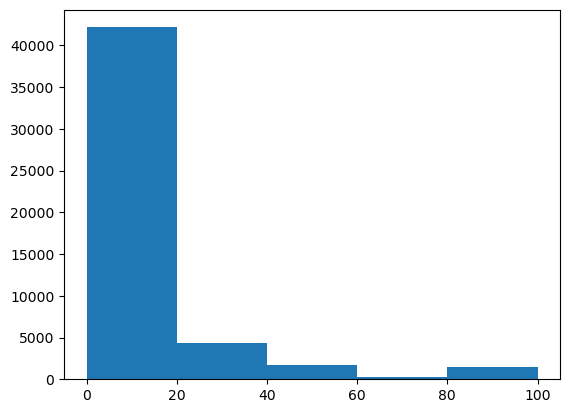

In [59]:
plt.hist(df.surge_pct, bins=5)
plt.show()

Most of the data falls under 20 for the surge_pct.

In [60]:
df.surge_pct.describe()

count    49992.000000
mean         8.850952
std         19.960094
min          0.000000
25%          0.000000
50%          0.000000
75%          8.600000
max        100.000000
Name: surge_pct, dtype: float64

This means that a majority of users don't have high surge percentages, but there is a small group of users that have a high percentage as well. 

### avg_surge<a id='avg_surge'></a>

● avg_surge: The average surge multiplier over all of this user’s trips

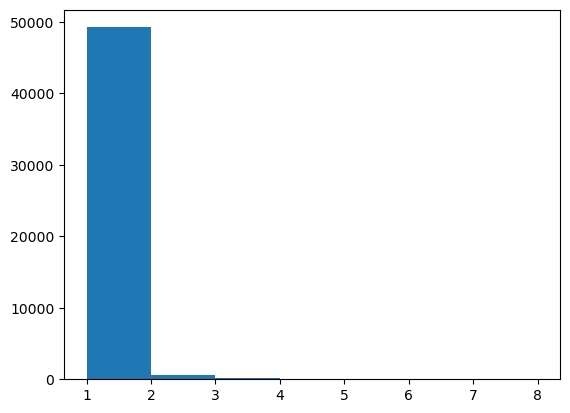

In [61]:
plt.hist(df.avg_surge, bins=7)
plt.show()

In [62]:
df.avg_surge.describe()

count    49992.000000
mean         1.074776
std          0.222352
min          1.000000
25%          1.000000
50%          1.000000
75%          1.050000
max          8.000000
Name: avg_surge, dtype: float64

We see similar results in the avg_surge where most of the values fall between 1-2. So if a user does have a surge, it's slightly above 1 as the mean is 1.07, but that number is propped up by the outliers as 75% of the data falls between 1-1.05. 

### trips_in_first_30_days<a id='trips_in_first_30_days'></a>

● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up

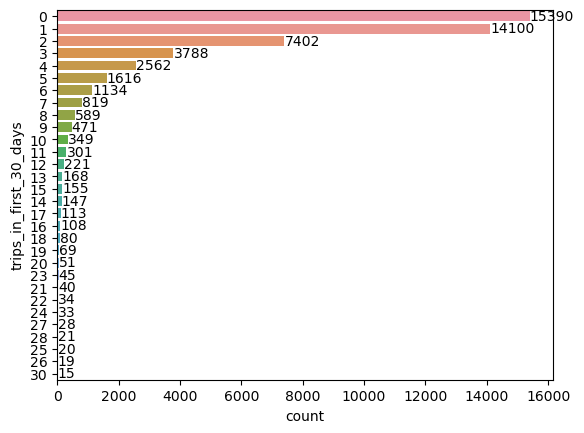

In [63]:
countplot(df,"trips_in_first_30_days",30,legend=False)

Looking at the number of trips in the first 30 days, we see that the most common values are the low values 0-2. A majority of the dataset did not do more than that. 

In [64]:
#Some of the big values don't make a lot of sense
df.trips_in_first_30_days.describe()

count    49992.000000
mean         2.278405
std          3.792953
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max        125.000000
Name: trips_in_first_30_days, dtype: float64

We can see the mean is around 2.27 trips, but we see a very high max in 125. Let's take a look at some of those higher values by looking at values over 70. 

In [65]:
#looks like these high end users may be taking the trips to and from work as their percentages are really high for weekday. 
df[df.trips_in_first_30_days > 70]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
99,Astapor,73,2014-01-27,4.9,1.00,2014-03-05,Android,0.0,True,89.7,2.86,4.9
3030,Winterfell,71,2014-01-06,4.9,1.06,2014-06-28,iPhone,2.9,True,85.9,2.32,4.8
18514,King's Landing,125,2014-01-02,5.0,1.12,2014-06-30,iPhone,14.4,True,72.0,2.02,4.8


We see that there are very few really high values, but they do exist. However, we can still reasonably accept these values as this most likely just means they used this service as their main means of transportation throughout the month. 

### ultimate_black_user<a id='ultimate_black_user'></a>

● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise

<AxesSubplot:xlabel='ultimate_black_user', ylabel='count'>

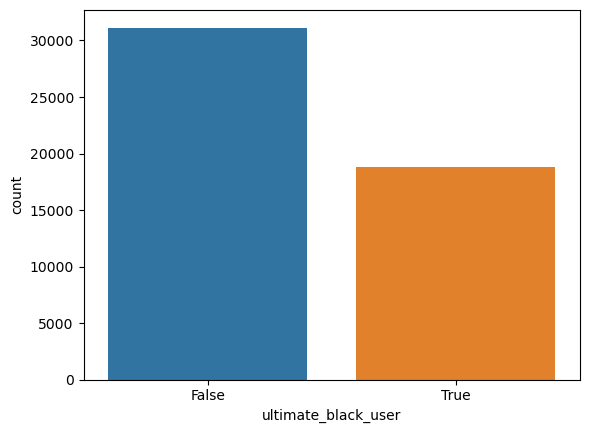

In [66]:
sns.countplot(data=df, x='ultimate_black_user')

We see a majority of the users did not use the Ultimate Black feature in the first 30 days, but around 40% did take one which is a decent amount for a premium service. 

### weekday_pct<a id='weekday_pct'></a>

● weekday_pct: the percent of the user’s trips occurring during a weekday

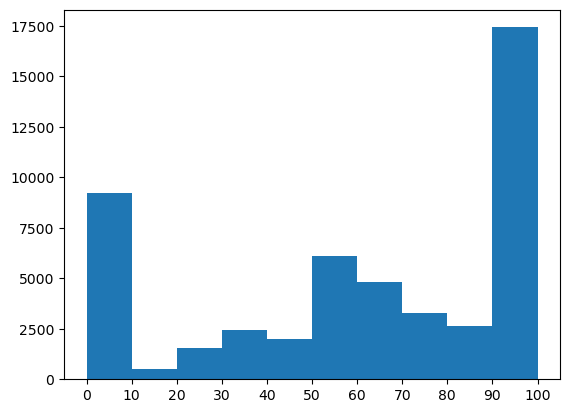

In [67]:
evenly_spaced_values = np.linspace(0, 100, num=11)
plt.hist(df.weekday_pct,bins=evenly_spaced_values)
plt.xticks(evenly_spaced_values)
plt.show()

For the weekday_pct, we see that there are two main buckets people fall into, either they use the service mostly during the week, or rarely during the week. There is also a small bump around the 50% mark as well. 

## Target Value<a id='Target_Value'>

After exploring the dataset a bit further, let's now create our target variable which will be the users that are considered retained based on having taken a trip in the last 30 days (as of 7/1/14).

In [68]:
max_date = df['last_trip_date'].max()

thirty_days_before = max_date - pd.DateOffset(days=30)

retained = df[df['last_trip_date']>thirty_days_before]

# take the length of retained and the original data, multiple by 100 to create a percentage, 
# round to 2 decimals and make it a string to display the percentage.
percent_retained = str(round((len(retained)/len(df)) * 100,2))+'%'

percent_retained

'36.63%'

Currently of the data, there are 36.63% of users currently retained as of 7/1. Let's add our column of retained to teh dataset where True means they are retained, and False means they are not retained. 

In [69]:
#Add Retained as a feature

df['retained'] = df['last_trip_date'] > thirty_days_before

df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.700000,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.000000,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.300000,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.600000,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.400000,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.000000,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2,True
49996,Astapor,1,2014-01-24,4.601512,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0,False
49997,Winterfell,0,2014-01-31,5.000000,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0,False
49998,Astapor,2,2014-01-14,3.000000,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5,False


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49992 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49992 non-null  object        
 1   trips_in_first_30_days  49992 non-null  int64         
 2   signup_date             49992 non-null  datetime64[ns]
 3   avg_rating_of_driver    49992 non-null  float64       
 4   avg_surge               49992 non-null  float64       
 5   last_trip_date          49992 non-null  datetime64[ns]
 6   phone                   49992 non-null  object        
 7   surge_pct               49992 non-null  float64       
 8   ultimate_black_user     49992 non-null  bool          
 9   weekday_pct             49992 non-null  float64       
 10  avg_dist                49992 non-null  float64       
 11  avg_rating_by_driver    49992 non-null  float64       
 12  retained                49992 non-null  bool  

We can see our row that we added so we should be good to move to our Analysis. 

## Analysis<a id='Analysis'>

1) Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

**After cleaning the data, we kept all but 8 duplicate rows (49,992/50,000 [99.984%]). I added an 'Other' value for phone for the missing values, the mean values for the missing avg_rating_of_driver and avg_rating_by_driver values, and converted the last_trip_date and signup_date to datetimes.**

**Of the observed users, we see 36.63% of the users were retained (last trip was within the last 30 days). We added our target column to the original data called "retained" and is True if they have taken a trip in the last 30 days.**

**Some interesting notes to the data after exploring the data:**

    - There were only 3 cities, "Winterfell", "Astapor" and "King's Landing". 
    
    - There were some really high values in trips_in_first_30_days, but the few high values could signal that they use the   driving service for all travel including to and from work and lunch. 
    
    - For the last_trip_date field, we see an initial spike toward the beginning for users that tried it and then stopped,  then dropped off until the most recent months when people are most likely to have used it recently for their latest     trip.
    
    - Most of the avg_dist values fall under 10 miles. 
    
    - Most users use Iphones (around 70%).  
    
    - The avg_rating_by_driver is slightly higher than avg_rating_of_driver, so that means the drivers are rating the customers higher on average than the customers are rating the drivers. However, most of the scores are very high as they both average in the upper 4's out of 5.
    

# Modeling<a id='Modeling'>

2) Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

## Train Test Split<a id='Train_Test_Split'>

Before we can run our model, we first need to split our data into training and testing sets. Before we do that, we'll need to create dummy columns for all the categorical variables to account for those with numbers so it can be used in our model. So the first thing we will do is convert the city, phone, and ultimate_black_user columns into these dummy columns. We will also convert the dates to day, month and year columns so the dates are split up and can be used as well. 

In [71]:
d_df = pd.get_dummies(df,columns=['city','phone','ultimate_black_user'], drop_first=True)

d_df['signup_Day'] = d_df['signup_date'].dt.day
d_df['signup_Month'] = d_df['signup_date'].dt.month
d_df['signup_Year'] = d_df['signup_date'].dt.year

d_df['last_trip_Day'] = d_df['last_trip_date'].dt.day
d_df['last_trip_Month'] = d_df['last_trip_date'].dt.month
d_df['last_trip_Year'] = d_df['last_trip_date'].dt.year

d_df

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retained,...,city_Winterfell,phone_Other,phone_iPhone,ultimate_black_user_True,signup_Day,signup_Month,signup_Year,last_trip_Day,last_trip_Month,last_trip_Year
0,4,2014-01-25,4.700000,1.10,2014-06-17,15.4,46.2,3.67,5.0,True,...,0,0,1,1,25,1,2014,17,6,2014
1,0,2014-01-29,5.000000,1.00,2014-05-05,0.0,50.0,8.26,5.0,False,...,0,0,0,0,29,1,2014,5,5,2014
2,3,2014-01-06,4.300000,1.00,2014-01-07,0.0,100.0,0.77,5.0,False,...,0,0,1,0,6,1,2014,7,1,2014
3,9,2014-01-10,4.600000,1.14,2014-06-29,20.0,80.0,2.36,4.9,True,...,0,0,1,1,10,1,2014,29,6,2014
4,14,2014-01-27,4.400000,1.19,2014-03-15,11.8,82.4,3.13,4.9,False,...,1,0,0,0,27,1,2014,15,3,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,2014-01-25,5.000000,1.00,2014-06-05,0.0,100.0,5.63,4.2,True,...,0,0,1,0,25,1,2014,5,6,2014
49996,1,2014-01-24,4.601512,1.00,2014-01-25,0.0,0.0,0.00,4.0,False,...,0,0,1,0,24,1,2014,25,1,2014
49997,0,2014-01-31,5.000000,1.00,2014-05-22,0.0,100.0,3.86,5.0,False,...,1,0,0,1,31,1,2014,22,5,2014
49998,2,2014-01-14,3.000000,1.00,2014-01-15,0.0,100.0,4.58,3.5,False,...,0,0,1,0,14,1,2014,15,1,2014


In [72]:
d_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49992 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   trips_in_first_30_days    49992 non-null  int64         
 1   signup_date               49992 non-null  datetime64[ns]
 2   avg_rating_of_driver      49992 non-null  float64       
 3   avg_surge                 49992 non-null  float64       
 4   last_trip_date            49992 non-null  datetime64[ns]
 5   surge_pct                 49992 non-null  float64       
 6   weekday_pct               49992 non-null  float64       
 7   avg_dist                  49992 non-null  float64       
 8   avg_rating_by_driver      49992 non-null  float64       
 9   retained                  49992 non-null  bool          
 10  city_King's Landing       49992 non-null  uint8         
 11  city_Winterfell           49992 non-null  uint8         
 12  phone_Other       

Now that our new columns have been created, we can create our X (dataframe of all our features) and y (target variable). For our y, we will use our target variable which is the retained column we created. For our X, we'll want to drop those non numeric values which include the signup_date, last_trip_date, and retained columns. We'll also want to drop any other values that would have information related to our target variable so the last_trip_Day, last_trip_Month, and last_trip_Year columns are removed as well. This could have been done in our previous step to not even create them, but I wanted to highlight this point here to make sure no information is related. 

In [73]:
X = d_df.drop(['signup_date', 'last_trip_date','retained', 'last_trip_Day', 'last_trip_Month', 'last_trip_Year'], axis=1)
y = pd.get_dummies(d_df['retained'], drop_first=True)

Now that our X and y have been created, let's take a look and make sure they look correct. 

In [74]:
X

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_King's Landing,city_Winterfell,phone_Other,phone_iPhone,ultimate_black_user_True,signup_Day,signup_Month,signup_Year
0,4,4.700000,1.10,15.4,46.2,3.67,5.0,1,0,0,1,1,25,1,2014
1,0,5.000000,1.00,0.0,50.0,8.26,5.0,0,0,0,0,0,29,1,2014
2,3,4.300000,1.00,0.0,100.0,0.77,5.0,0,0,0,1,0,6,1,2014
3,9,4.600000,1.14,20.0,80.0,2.36,4.9,1,0,0,1,1,10,1,2014
4,14,4.400000,1.19,11.8,82.4,3.13,4.9,0,1,0,0,0,27,1,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,5.000000,1.00,0.0,100.0,5.63,4.2,1,0,0,1,0,25,1,2014
49996,1,4.601512,1.00,0.0,0.0,0.00,4.0,0,0,0,1,0,24,1,2014
49997,0,5.000000,1.00,0.0,100.0,3.86,5.0,0,1,0,0,1,31,1,2014
49998,2,3.000000,1.00,0.0,100.0,4.58,3.5,0,0,0,1,0,14,1,2014


In [75]:
y

,True
0,1
1,0
2,0
3,1
4,0
...,...
49995,1
49996,0
49997,0
49998,0


They look to be correct so we can move on to splitting our data. We will create a training set of 80% of our data (39,993), and a test set of 20% of our data (9999). 

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

Now that we have created our training and testing sets, we will need to scale all the values related to our X variable, so we will use a Standard Scaler using the training set and then apply that to the training and testing sets. 

## Scaling the Data <a id ='Scaling_the_Data'>

In [77]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

Let's review to make sure it looks correct. 

In [78]:
X_train_scaled

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_King's Landing,city_Winterfell,phone_Other,phone_iPhone,ultimate_black_user_True,signup_Day,signup_Month,signup_Year
0,0.192740,0.527473,0.067500,0.097765,0.546608,-0.711682,0.051315,1.978167,-0.934034,-0.088097,0.665863,1.286693,-0.749543,0.0,0.0
1,-0.599555,0.704178,-0.335620,-0.444080,-1.640129,5.574082,0.499161,-0.505518,1.070625,-0.088097,0.665863,-0.777186,-1.320734,0.0,0.0
2,0.192740,-0.532757,-0.335620,-0.444080,1.056218,-0.441944,0.499161,-0.505518,1.070625,-0.088097,0.665863,-0.777186,-1.777688,0.0,0.0
3,-0.335457,0.704178,-0.335620,-0.444080,-1.640129,2.368551,-0.620453,-0.505518,-0.934034,-0.088097,-1.501810,-0.777186,-0.521066,0.0,0.0
4,-0.335457,0.704178,-0.335620,-0.444080,1.056218,-0.381035,0.499161,-0.505518,1.070625,-0.088097,0.665863,1.286693,1.535223,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39988,-0.071359,-2.299808,0.784158,1.226608,-1.640129,-0.692539,0.499161,1.978167,-0.934034,-0.088097,0.665863,-0.777186,0.164363,0.0,0.0
39989,-0.599555,-1.062872,-0.335620,-0.444080,-1.640129,-0.318387,0.499161,-0.505518,1.070625,-0.088097,0.665863,-0.777186,1.306746,0.0,0.0
39990,-0.071359,0.704178,-0.335620,-0.444080,-0.742246,0.128856,0.499161,-0.505518,-0.934034,-0.088097,0.665863,1.286693,-0.178351,0.0,0.0
39991,-0.599555,0.704178,-0.335620,-0.444080,1.056218,5.288681,0.499161,-0.505518,1.070625,-0.088097,0.665863,-0.777186,-0.863781,0.0,0.0


Everything looks to be scaled. Let's confirm our y_train looks correct as well. 

In [79]:
y_train

array([1, 0, 0, ..., 0, 0, 0], dtype=uint8)

It does, so now we can move into our modeling. We will start with a Logistic Regression model to see how it performs. First we will find the best value of C to tune our hyperparameter. 

## Logistic Regression <a id='Logistic_Regression'>

In [80]:
#Binary Classifcation (Active or Not after 6 months). Will use Logistic Regression for my model. 

c_values = [0.01, 0.4, 0.5, 1]
accuracy_scores = []
for C in c_values:
    logreg = LogisticRegression(max_iter=100, C=C)
    logreg.fit(X_train_scaled,y_train)
    y_pred = logreg.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    
# Find the index of the C value with the highest accuracy
best_index = accuracy_scores.index(max(accuracy_scores))
best_C = c_values[best_index]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Best C:", best_C)
print("Accuracy:", accuracy)

Best C: 0.4
Accuracy: 0.7233723372337234


We see the best C value is 0.4 which results in the highest acccuracy score. We will use that to create our actual model.

In [81]:
logreg = LogisticRegression(max_iter=100, C=0.4)
logreg.fit(X_train_scaled,y_train)

y_pred_test = logreg.predict(X_test_scaled)

logreg.score(X_test_scaled, y_test)

0.7233723372337234

Now that our initial model has been created, let's see how it performs. First we can look at the ROC Curve to see how well it's True Positive vs False Positive rate is. 

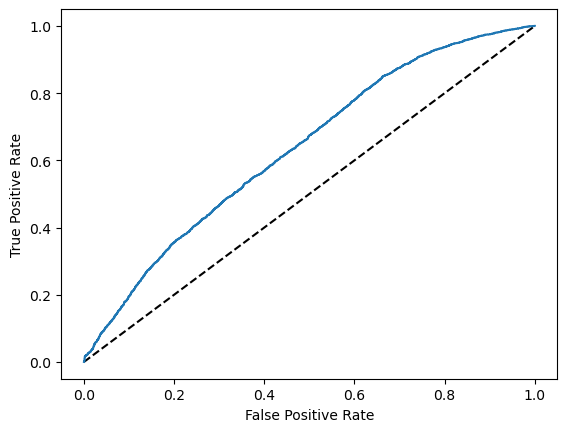

In [82]:
Y_pred_probs = logreg.predict_proba(X_test)
Y_pred_probs[60][0]

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, Y_pred_probs[:,1])   # Predicting a 1 which is retained
#fpr2, tpr2, thresholds2 = roc_curve(y_test, Y_pred_probs[:,0]) # Predicting a 0 which is not retained
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.plot(fpr2, tpr2)
plt.show()

We see slightly imporoved performance from randomly guessing, so we see our model does have some value. Let's take a look at some of the metrics for this model. 

In [83]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.74      0.86      0.80      6290
           1       0.68      0.49      0.57      3709

    accuracy                           0.72      9999
   macro avg       0.71      0.67      0.68      9999
weighted avg       0.72      0.72      0.71      9999



The 1 in our report represents a retained customer, so we see around 68% for precision which means there are a lot of false positives with our model. Let's review the confusion matrix to review the overall performance

In [84]:
print(confusion_matrix(y_test, y_pred_test))

[[5433  857]
 [1909 1800]]


Here are the results of our confusion matrix:

**TRUE POSITIVE**: 1800

**TRUE NEGATIVE**: 5433

**FALSE POSITIVE**: 857 

**FALSE NEGATIVE**: 1909

We see it predicts a majority of the negative values correctly, but still a relatively high percentage of False positives. Let's check out which features the model thought was important. 

In [85]:
feature_cos = logreg.coef_[0]

feature_names= X_train_scaled.columns
coef_dict = dict(zip(feature_names, feature_cos))

sorted_coef = sorted(coef_dict.items(), key=lambda x: abs(x[1]), reverse=True)

for feature, coef in sorted_coef:
    print(f"{feature}: {coef}")

city_King's Landing: 0.713005245245437
phone_iPhone: 0.5369985530327109
trips_in_first_30_days: 0.4559916787128399
ultimate_black_user_True: 0.43355591413946776
city_Winterfell: 0.263619726865836
avg_dist: -0.20632561579382588
surge_pct: 0.08008602762361086
avg_rating_by_driver: -0.07215392968386945
signup_Day: -0.052603995580010075
phone_Other: 0.05126067668653683
weekday_pct: 0.04581236484498306
avg_surge: -0.032383944920812945
avg_rating_of_driver: -0.02974729638525522
signup_Month: 0.0
signup_Year: 0.0


Some insights we glean from the model is that if the user is from King's Landing, that greatly improves the liklihood the model will say there will be retention. It also highly values if the user has an Iphone, the user took a trip in the first 30 days, and the user was an ultimate black user. For negative impacts, the greatest one was if the avg_dist was really high, they were less likely to be retained. 

Let's now look at a Random Forest model to see if we can get better results. 

## Random Forest <a id='Random_Forest'>

In [86]:
n_estimator_values = [ 150, 200, 250, 300]
accuracy_scores = []
for n in n_estimator_values:
    rf_classifier = RandomForestClassifier(n_estimators=n,random_state=42)
    rf_classifier.fit(X_train_scaled,y_train)
    y_pred = rf_classifier.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    
# Find the index of the C value with the highest accuracy
best_index = accuracy_scores.index(max(accuracy_scores))
best_n = n_estimator_values[best_index]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Best n_estimator:", best_n)
print("Accuracy:", accuracy)

Best n_estimator: 200
Accuracy: 0.7786778677867787


We see that our best estimator is 200, so let's create our model now and then look at the scores. 

In [87]:
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42)

rf_classifier.fit(X_train_scaled, y_train)

y_pred_test = rf_classifier.predict(X_test_scaled)

rf_classifier.score(X_test_scaled, y_test)

0.7796779677967797

In [88]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      6290
           1       0.73      0.64      0.68      3709

    accuracy                           0.78      9999
   macro avg       0.77      0.75      0.76      9999
weighted avg       0.78      0.78      0.78      9999



We see improvements in all the metrics when compared to the Logistic Regression model so this is overall a better model. We are still seeing a relatively low recall score when predicting a retained user, but is much better than the Logistic Regression model. Let's review the confusion matrix. 

In [89]:
print(confusion_matrix(y_test, y_pred_test))

[[5408  882]
 [1321 2388]]


**TRUE POSITIVE**: 2388  

**TRUE NEGATIVE**: 5408

**FALSE POSITIVE**: 882 

**FALSE NEGATIVE**: 1321 

We see over 800 more correct positive predictions, but slightly less true negative predictions. However, since we want to see all the retained users, overall, this model performs better than the Logistic Regression model, so this would be the top model of the two. Ideally, we would want an even higher score for predicting those true values, so some further tuning for the hyperparameters may be needed. Let's review what features the model thought were important. 

In [90]:
feature_importance = rf_classifier.feature_importances_

feature_names= X_train_scaled.columns

importance_dict = dict(zip(feature_names, feature_importance))

sorted_importance = sorted(importance_dict.items(), key=lambda x: abs(x[1]), reverse=True)

for feature, importance in sorted_importance:
    print(f"{feature}: {importance}")

avg_dist: 0.20585548299293602
signup_Day: 0.13362914486757288
weekday_pct: 0.11646021601586497
avg_rating_by_driver: 0.1064752850834687
surge_pct: 0.07602279121808128
trips_in_first_30_days: 0.07508637984597306
avg_rating_of_driver: 0.07244033641061928
city_King's Landing: 0.06451977048883405
avg_surge: 0.062070459614738664
phone_iPhone: 0.03906572692862871
ultimate_black_user_True: 0.032016722329211586
city_Winterfell: 0.014699843684144412
phone_Other: 0.0016578405199263529
signup_Month: 0.0
signup_Year: 0.0


Looking at the important features, we see that avg_dist is the most important. In this case, the higher the distance, the more they are likely to be retained which is the opposite of what the Logistic Regression model found. That may be something to further explore. We also see that a lot of the other features are weighed relatively close to each other with signup_Day, weekday_pct, and avg_rating_by_driver hovering in the .10-.13 range. Some lower positive features look to be the type of phone, the ultimate_black_user_True, and the city_Winterfell. 

# Conclusion<a id='Conclusion'>

3) Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

**Ultimate can leverage these insights to improve rider retention by seeing the common features that are of high importance between the two models. The main areas of high retention seem to be anyone from King's Landing, anyone who takes a trip in the first 30 days, and users with a high weekday usage percentage. Seeing some of these important factors can help identify some things to target when marketing to people, or trying to find some further reasons for why the retention is performing well for these categories.**  